In [ ]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 21.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=30b887a80409098c44f9e8e2746022b6d7932464bda6c8310a15c8a6232f07d1
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric


In [ ]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero
import torch


dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64, out_channels=dataset.num_classes)
model = to_hetero(model, data.metadata(), aggr='sum')

In [ ]:
with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

In [ ]:
from torch_geometric.nn import GATConv, Linear, to_hetero

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x


model = GAT(hidden_channels=64, out_channels=dataset.num_classes)
model = to_hetero(model, data.metadata(), aggr='sum')

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['paper'].train_mask
    loss = F.cross_entropy(out['paper'][mask], data['paper'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, Linear

class Model(torch.nn.Module):
    def __init__(self, num_users, num_items, num_sellers, embedding_dim):
        super(Model, self).__init__()
        self.embedding_dim = embedding_dim

        # Define node embeddings
        self.user_embedding = torch.nn.Embedding(num_users, embedding_dim)
        self.item_embedding = torch.nn.Embedding(num_items, embedding_dim)
        self.seller_embedding = torch.nn.Embedding(num_sellers, embedding_dim)

        # Define edge types
        self.edge_index_dict = {
            ('user', 'purchased', 'item'): (torch.tensor([[], []]), torch.tensor([])),
            ('item', 'sold_by', 'seller'): (torch.tensor([[], []]), torch.tensor([]))
        }

        # Define the HeteroData object
        self.data = HeteroData()

        # Add node features
        self.data['user'].x = self.user_embedding.weight
        self.data['item'].x = self.item_embedding.weight
        self.data['seller'].x = self.seller_embedding.weight

        # Define HeteroConv layers
        self.conv1 = HeteroConv({
            ('user', 'purchased', 'item'): torch.nn.Linear(embedding_dim, embedding_dim)
        })
        self.conv2 = HeteroConv({
            ('item', 'sold_by', 'seller'): torch.nn.Linear(embedding_dim, embedding_dim)
        })

        # Define final linear layers
        self.fc1 = Linear(embedding_dim, num_items)
        self.fc2 = Linear(embedding_dim, num_sellers)

    def forward(self, user_indices):
        # Get node embeddings
        user_embed = self.user_embedding(user_indices)
        item_embed, _ = self.conv1(self.data, self.edge_index_dict)
        seller_embed, _ = self.conv2(self.data, self.edge_index_dict)

        # Apply final linear layers
        item_pred = self.fc1(item_embed['item'])
        seller_pred = self.fc2(seller_embed['seller'])

        return item_pred, seller_pred

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, Linear
from sklearn.metrics import mean_squared_error

# Define model hyperparameters
num_users = 1000
num_items = 500
num_sellers = 100
embedding_dim = 32

# Instantiate the model
model = Model(num_users, num_items, num_sellers, embedding_dim)

# Generate random data
num_examples = 10000
user_indices = torch.randint(0, num_users, (num_examples,))
item_indices = torch.randint(0, num_items, (num_examples,))
seller_indices = torch.randint(0, num_sellers, (num_examples,))

# Preprocess data
edges = []
edge_types = []
for buyer, item, seller in zip(user_indices, item_indices, seller_indices):
    edges.append((buyer.item(), item.item()))
    edge_types.append(0)
    edges.append((item.item(), seller.item()))
    edge_types.append(1)

data = HeteroData()
data['user'].num_nodes = num_users
data['item'].num_nodes = num_items
data['seller'].num_nodes = num_sellers
data['user', 'purchased', 'item'].edge_index = torch.tensor(edges[::2], dtype=torch.long).t().contiguous()
data['item', 'sold_by', 'seller'].edge_index = torch.tensor(edges[1::2], dtype=torch.long).t().contiguous()
data['user', 'purchased', 'item'].edge_type = torch.tensor(edge_types[::2], dtype=torch.long)
data['item', 'sold_by', 'seller'].edge_type = torch.tensor(edge_types[1::2], dtype=torch.long)

# Evaluate model on data
item_pred, seller_pred = model(user_indices)
item_pred = F.softmax(item_pred, dim=1)
seller_pred = F.softmax(seller_pred, dim=1)

item_labels = torch.zeros((num_examples, num_items))
seller_labels = torch.zeros((num_examples, num_sellers))
for i, (item, seller) in enumerate(zip(item_indices, seller_indices)):
    item_labels[i][item] = 1
    seller_labels[i][seller] = 1

item_loss = F.binary_cross_entropy(item_pred, item_labels)
seller_loss = F.binary_cross_entropy(seller_pred, seller_labels)
total_loss = item_loss + seller_loss

item_preds = torch.argmax(item_pred, dim=1)
item_true = item_indices.detach().cpu().numpy()
seller_preds = torch.argmax(seller_pred, dim=1)
seller_true = seller_indices.detach().cpu().numpy()

item_acc = (item_preds == item_true).sum() / num_examples
seller_acc = (seller_preds == seller_true).sum() / num_examples
item_mse = mean_squared_error(item_pred.detach().cpu().numpy(), item_labels.detach().cpu().numpy())
seller_mse = mean_squared_error(seller_pred.detach().cpu().numpy(), seller_labels.detach().cpu().numpy())

print(f"Item Accuracy: {item_acc:.4f}")
print(f"Seller Accuracy: {seller_acc:.4f}")
print(f"Item MSE: {item_mse:.4f}")
print(f"Seller MSE: {seller_mse:.4f}")


TypeError: ignored

In [8]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class HeteroNet(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_type):
        super(HeteroNet, self).__init__(aggr='mean')
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.edge_type = edge_type

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        return x_j if self.edge_type == 'user-item' else self.lin(x_j)

    def update(self, aggr_out):
        return self.lin(aggr_out)

class Model(torch.nn.Module):
    def __init__(self, num_users, num_items, num_sellers, embedding_dim):
        super(Model, self).__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_dim)
        self.item_embedding = torch.nn.Embedding(num_items, embedding_dim)
        self.seller_embedding = torch.nn.Embedding(num_sellers, embedding_dim)

        self.user_item_edge = ('user', 'purchased', 'item')
        self.item_seller_edge = ('item', 'sold_by', 'seller')
        
        self.user_item_net = HeteroNet(embedding_dim, embedding_dim, 'user-item')
        self.item_seller_net = HeteroNet(embedding_dim, embedding_dim, 'item-seller')

        self.user_item_pred = torch.nn.Linear(embedding_dim, num_items)
        self.item_seller_pred = torch.nn.Linear(embedding_dim, num_sellers)

    def forward(self, user_indices):
        user_embed = self.user_embedding(user_indices)
        item_embed = self.user_item_net(user_embed, self.user_item_edge)
        item_pred = self.user_item_pred(item_embed)

        _, item_indices = torch.topk(item_pred, k=1)
        item_indices = item_indices.squeeze()

        item_embed = self.item_embedding(item_indices)
        seller_embed = self.item_seller_net(item_embed, self.item_seller_edge)
        seller_pred = self.item_seller_pred(seller_embed)

        return item_pred, seller_pred


In [9]:
import numpy as np
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Generate fake data
num_users = 100
num_items = 200
num_sellers = 50
embedding_dim = 16

# Generate user, item, seller, and timestamp data
users = torch.LongTensor(np.random.randint(0, num_users, (1000,)))
items = torch.LongTensor(np.random.randint(0, num_items, (1000,)))
sellers = torch.LongTensor(np.random.randint(0, num_sellers, (1000,)))
timestamps = torch.FloatTensor(np.random.randint(0, 100, (1000,)))

# Create edge index tensors
user_item_edge_index = torch.stack([users, items], dim=0)
item_seller_edge_index = torch.stack([items, sellers], dim=0)

# Create model instance and define loss and optimizer
model = Model(num_users, num_items, num_sellers, embedding_dim)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model for 10 epochs
for epoch in range(10):
    item_pred, seller_pred = model(users)

    item_loss = criterion(item_pred, items)
    seller_loss = criterion(seller_pred, sellers)
    loss = item_loss + seller_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1} - Item Loss: {item_loss.item():.4f}, Seller Loss: {seller_loss.item():.4f}") 


AttributeError: ignored

In [3]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 23.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=2f4aa1b6aee1a81ddc342cd8569be11a2b7d3f4195156d2a3ea1ed68a9d1fbba
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric


In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

# Define the number of nodes for each type of node
num_buyers = 100
num_sellers = 50
num_items = 200

# Create a bipartite graph with buyers, sellers, and items as nodes
buyer_nodes = torch.arange(num_buyers)
seller_nodes = torch.arange(num_buyers, num_buyers+num_sellers)
item_nodes = torch.arange(num_buyers+num_sellers, num_buyers+num_sellers+num_items)
buyer_indices = torch.randint(num_buyers, (num_buyers*num_items,))
item_indices = torch.randint(num_items, (num_buyers*num_items,))
edge_index = torch.stack([buyer_nodes[buyer_indices], item_nodes[item_indices]])

num_buyers = 200
num_sellers = 150
num_items = 50

# Construct the graph
edge_index = torch.tensor([
    [i, num_buyers+j] for i, j in zip(item_indices, buyer_indices)] +
    [[num_buyers+i, num_buyers+num_sellers+j] for i, j in zip(item_indices, seller_indices)]
).t().contiguous()
edge_index, _ = add_remaining_self_loops(edge_index)
x = torch.cat([buyer_nodes, seller_nodes, item_nodes], dim=0)

# Set the num_nodes parameter of Data
data = Data(x=x, edge_index=edge_index, num_nodes=num_buyers+num_sellers+num_items)

# Define a GNN that learns node embeddings for buyers, sellers, and items
class HeteroGNN(MessagePassing):
    def __init__(self, hidden_channels):
        super(HeteroGNN, self).__init__(aggr='mean')
        self.buyer_proj = torch.nn.Linear(hidden_channels, hidden_channels)
        self.seller_proj = torch.nn.Linear(hidden_channels, hidden_channels)
        self.item_proj = torch.nn.Linear(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        row, col = edge_index
        buyer_x, seller_x, item_x = x[:num_buyers], x[num_buyers:num_buyers+num_sellers], x[num_buyers+num_sellers:]
        buyer_x = self.buyer_proj(buyer_x)
        seller_x = self.seller_proj(seller_x)
        item_x = self.item_proj(item_x)

        # Compute embeddings for buyers and items using message passing
        out = self.propagate(edge_index, x=item_x)
        buyer_emb = out[row == buyer_nodes]
        item_emb = out[row == item_nodes]

        # Concatenate buyer and item embeddings and pass through a MLP to predict likelihood of purchase
        cat_emb = torch.cat([buyer_emb, item_emb], dim=-1)
        out = torch.nn.functional.relu(torch.nn.Linear(2*hidden_channels, hidden_channels)(cat_emb))
        out = torch.nn.functional.softmax(torch.nn.Linear(hidden_channels, 1)(out), dim=0)

        # Compute embeddings for items and sellers using message passing
        out = self.propagate(edge_index, x=buyer_x)
        item_emb = out[col == item_nodes]
        seller_emb = out[col == seller_nodes]

        # Concatenate item and seller embeddings and pass through a MLP to predict the seller
        cat_emb = torch.cat([item_emb, seller_emb], dim=-1)
        out = torch.nn.functional.relu(torch.nn.Linear(2*hidden_channels, hidden_channels)(cat_emb))
        out = torch.nn.functional.softmax(torch.nn.Linear(hidden_channels, num_sellers)(out), dim=-1)

        return out

# Set the hidden dimension of the node embeddings and instantiate the GNN
hidden_channels = 16
model = HeteroGNN(hidden_channels)

# Generate random initial node embeddings
x = torch.randn(num_buyers+num_sellers+num_items, hidden_channels)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [5]:
# Train the model for 1000 epochs
for epoch in range(1000):
    optimizer.zero_grad()
    out = model(x, edge_index)
    loss = criterion(out[item_indices], seller_nodes[buyer_indices])
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Make a prediction for a buyer purchasing an item
buyer_id = 42
item_id = 17
buyer_emb = model(x, edge_index)[buyer_id]
item_emb = model(x, edge_index)[num_buyers+num_sellers+item_id]
cat_emb = torch.cat([buyer_emb, item_emb], dim=-1)
out = torch.nn.functional.relu(torch.nn.Linear(2*hidden_channels, hidden_channels)(cat_emb))
out = torch.nn.functional.softmax(torch.nn.Linear(hidden_channels, 1)(out), dim=0)
print(f'Buyer {buyer_id} purchasing Item {item_id} with probability {out.item()}')

# Predict the seller for the item
item_emb = model(x, edge_index)[num_buyers+num_sellers+item_id]
out = model(x, edge_index)
out = torch.nn.functional.relu(torch.nn.Linear(hidden_channels, hidden_channels)(item_emb))
out = torch.nn.functional.softmax(torch.nn.Linear(hidden_channels, num_sellers)(out), dim=-1)
seller_id = seller_nodes[out.argmax()]
print(f'Predicted seller for Item {item_id}: {seller_id}')

ValueError: ignored

In [6]:
num_buyers = 200
num_sellers = 150
num_items = 50

# Construct the graph
edge_index = torch.tensor([
    [i, num_buyers+j] for i, j in zip(item_indices, buyer_indices)] +
    [[num_buyers+i, num_buyers+num_sellers+j] for i, j in zip(item_indices, seller_indices)]
).t().contiguous()
edge_index, _ = add_remaining_self_loops(edge_index)
x = torch.cat([buyer_nodes, seller_nodes, item_nodes], dim=0)

# Set the num_nodes parameter of Data
data = Data(x=x, edge_index=edge_index, num_nodes=num_buyers+num_sellers+num_items)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
class HeteroNet(torch.nn.Module):
    def __init__(self):
        super(HeteroNet, self).__init__()

        self.buyer_embedding = torch.nn.Embedding(num_buyers, 16)
        self.seller_embedding = torch.nn.Embedding(num_sellers, 16)
        self.item_embedding = torch.nn.Embedding(num_items, 16)

        self.conv1 = HeteroConv({
            'buyer': (16, 32),
            'seller': (16, 32),
            'item': (16, 32)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            'buyer': (32, 1),
            'item': (32, 1)
        }, aggr='mean')

        self.lin1 = torch.nn.Linear(32, 16)
        self.lin2 = torch.nn.Linear(16, 1)

    def forward(self, x_buyer, x_item, edge_index_buyer, edge_index_item):
        x_buyer = self.buyer_embedding(x_buyer)
        x_item = self.item_embedding(x_item)

        x = {'buyer': x_buyer, 'item': x_item}
        edge_index = {'buyer': edge_index_buyer, 'item': edge_index_item}

        x = self.conv1(x, edge_index)
        x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index)

        x = torch.cat([x['buyer'], x['item']], dim=1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

model = HeteroNet().to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# Train the model for 1000 epochs
for epoch in range(1000):
    model.train()

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    out = model(data.x[:num_buyers], data.x[num_buyers:num_buyers+num_items], data.edge_index[:,:-1], data.edge_index[:,1:])
    y_true = torch.tensor(y_train).unsqueeze(1).to(device)
    loss = criterion(out, y_true)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}') 


NameError: ignored

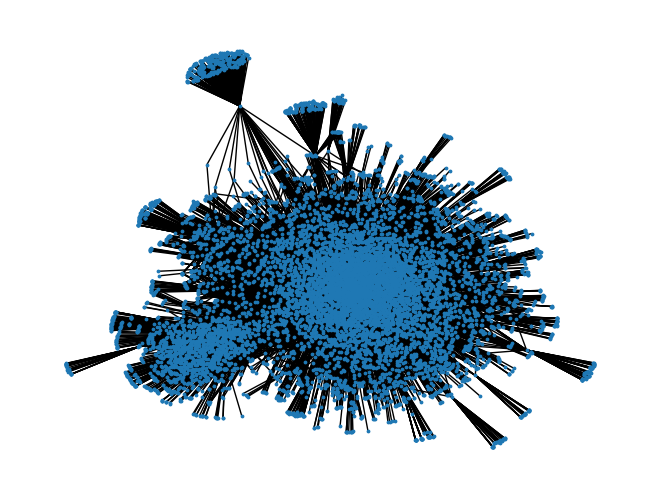

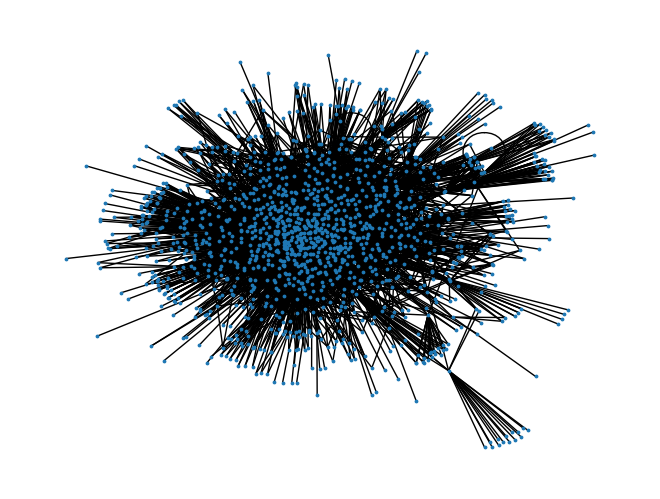

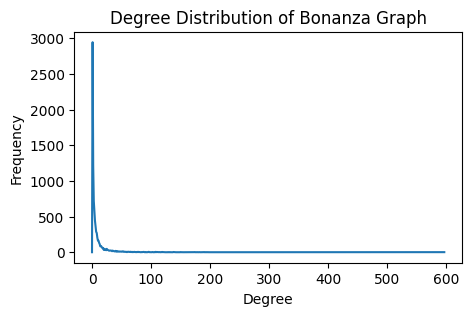

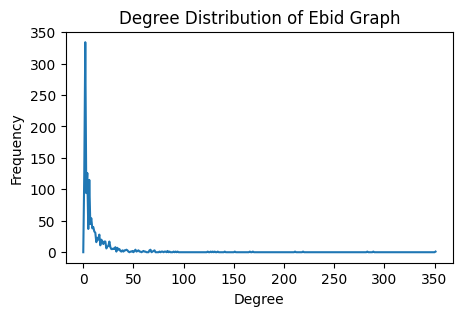

Number of Nodes:  8922
Number of Edges:  40742
Density:  0.0010237562870036498
Average local clustering coefficient:  0.019015337875993604
Average Degree centrality:  0.0010237562870034549
Average Betweenness centrality:  0.0003193139781634166
Average Eigenvector centrality:  0.003785521971887392
Average Closeness centrality:  0.26346214731475665
Pearson Correlation between Closeness and Betweenness Centrality:  PearsonRResult(statistic=0.29060477426063325, pvalue=3.652030707072068e-173)
Pearson Correlation between Betweenness and Eigenvector Centrality:  PearsonRResult(statistic=0.5448322679535169, pvalue=0.0)
Pearson Correlation between Eigenvector and Closeness Centrality:  PearsonRResult(statistic=0.6831700585832975, pvalue=0.0)
Average Shortest Path Length:  2974.3333333333335
Time in Minutes:  14.011153173446655


Number of Nodes:  1432
Number of Edges:  8548
Density:  0.008342800479408469
Average local clustering coefficient:  0.13840105590639756
Average Degree centrality:  0.008342800479408462
Average Betweenness centrality:  0.0014987902992540814
Average Eigenvector centrality:  0.013623187032436954
Average Closeness centrality:  0.32406340063080163
Pearson Correlation between Closeness and Betweenness Centrality:  PearsonRResult(statistic=0.4313940849037821, pvalue=5.571580639847524e-66)
Pearson Correlation between Betweenness and Eigenvector Centrality:  PearsonRResult(statistic=0.7180181814100618, pvalue=2.634589580685656e-227)
Pearson Correlation between Eigenvector and Closeness Centrality:  PearsonRResult(statistic=0.7966818328112045, pvalue=5.195185403e-315)
Average Shortest Path Length:  477.6666666666667
Time in Minutes:  0.27878922621409097
